## Nama : Alif Adwitiya Pratama

# Recommender System - Anime Recommendation

### 1. Persiapan

#### 1.1 Masukkan Library

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
tf.test.gpu_device_name()

#remove warning
import warnings
warnings.filterwarnings('ignore')

#### 1.2 Masukkan Data

In [101]:
dfAnime=pd.read_csv('./data/anime.csv')
#hanya menggunakan 100.000 data pertama
dfRating=pd.read_csv('./data/rating.csv',nrows=100000)

### 2. Data Understanding

dataset yang digunakan dapat diakses [disini](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)

#### 2.1 Tentang Dataset

**Deskripsi**<br>
dataset ini berisi tentang data rating anime yang diambil dari [myanimelist.net](https://myanimelist.net/). Dataset ini berisi informasi tentang data preferensi pengguna dari 7.813.737 pengguna pada 12.294 anime yang berbeda yang dipisah kedalam dua dataset yaitu anime.csv yang berisi terkait informasi anime dan rating.csv yang berisi terkait rating user. Data ini diambil dari link kaggle [berikut.](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)

**Tentang Fitur** <br>

Dataset **anime.csv** -> dapat digunakan untuk content based filtering

- anime_id - id unik yang mengidentifikasi sebuah anime
- name - nama lengkap anime
- genre - daftar genre anime yang dipisahkan oleh koma
- type - tipe anime (film, TV, OVA, dll)
- episodes - jumlah episode dalam sebuah anime (1 jika film)
- rating - rata-rata rating dari 10 untuk anime tersebut
- members - jumlah anggota komunitas yang ada di grup anime tersebut

Dataset **Rating.csv** -> dapat digunakan untuk collaborative filtering

- user_id - id pengguna yang tidak dapat diidentifikasi secara acak
- anime_id - anime yang telah dinilai oleh pengguna tersebut
- rating - rating dari 10 yang diberikan oleh pengguna tersebut (-1 jika pengguna menonton anime tersebut tapi tidak memberikan rating)





#### 2.2 Deskripsi Data


##### 2.2.1 Anime.csv

In [102]:
#sample data
dfAnime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [103]:
#shape data
print(dfAnime.shape)

(12294, 7)


In [104]:
# data type
dfAnime.info()

# episode perlu diperbaiki karena seharusnya integer
dfAnime['episodes']=dfAnime['episodes'].replace('Unknown',np.nan)
dfAnime['episodes']=dfAnime['episodes'].astype(float)

print('\n\nsesudah diperbaiki\n')

dfAnime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


sesudah diperbaiki

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  11954 non-null  float64
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int6

In [105]:
# check null
display(dfAnime.isnull().sum())


anime_id      0
name          0
genre        62
type         25
episodes    340
rating      230
members       0
dtype: int64

In [106]:
# check duplicate
print('jumlah data duplikat : ',dfAnime.duplicated().sum())

jumlah data duplikat :  0


In [107]:
# check deskripsi statistik
dfAnime.describe(include='all')


,anime_id,name,genre,type,episodes,rating,members
count,12294.000000,12294,12232,12269,11954.000000,12064.000000,1.229400e+04
unique,NaN,12292,3264,6,NaN,NaN,NaN
top,NaN,Shi Wan Ge Leng Xiaohua,Hentai,TV,NaN,NaN,NaN
freq,NaN,2,823,3787,NaN,NaN,NaN
mean,14058.221653,NaN,NaN,NaN,12.382550,6.473902,1.807134e+04
std,11455.294701,NaN,NaN,NaN,46.865352,1.026746,5.482068e+04
min,1.000000,NaN,NaN,NaN,1.000000,1.670000,5.000000e+00
25%,3484.250000,NaN,NaN,NaN,1.000000,5.880000,2.250000e+02
50%,10260.500000,NaN,NaN,NaN,2.000000,6.570000,1.550000e+03
75%,24794.500000,NaN,NaN,NaN,12.000000,7.180000,9.437000e+03


dari tabel diatas terdapat informasi bahwa :
- Terdapat 2 judul anime yang sama tapi memiliki id berbeda
- Terdapat 12.292 judul anime yang unik
- Genre anime terdiri dari 3.264 jenis kombinasi genre berbeda
- Tipe anime terdiri dari 6 jenis yang berbeda
- Range jumlah episode anime sangat bervariasi, mulai dari 1  hingga 1818 episode dengan rata-rata 12 episode
- Rating rata-rata anime adalah 6,47 dari skala 1 hingga 10
- Jumlah rata-rata anggota komunitasi yang ada di grup anime adalah 1.807


In [108]:
# nama anime yang duplikat
dfAnime[dfAnime.name.duplicated(keep=False)].sort_values(by='name')

#karna berbeda tidak perlu di drop

,anime_id,name,genre,type,episodes,rating,members
10140,22399,Saru Kani Gassen,Kids,OVA,1.0,5.23,62
10141,30059,Saru Kani Gassen,Drama,Movie,1.0,4.75,76
10193,33193,Shi Wan Ge Leng Xiaohua,"Comedy, Parody",ONA,12.0,6.67,114
10194,33195,Shi Wan Ge Leng Xiaohua,"Action, Adventure, Comedy, Fantasy, Parody",Movie,1.0,7.07,110


##### 2.2.2 Rating.csv

In [109]:
#sample data
dfRating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [110]:
#shape data
print(dfRating.shape)

(100000, 3)


In [111]:
# data type
dfRating.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   100000 non-null  int64
 1   anime_id  100000 non-null  int64
 2   rating    100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


In [112]:
# check null
print('jumlah data null :\n',dfRating.isnull().sum())


jumlah data null :
 user_id     0
anime_id    0
rating      0
dtype: int64


In [113]:
# check deskripsi statistik
dfRating.describe()


,user_id,anime_id,rating
count,100000.000000,100000.000000,100000.000000
mean,529.151490,10941.254160,6.112450
std,290.143014,9138.518083,3.782997
min,1.000000,1.000000,-1.000000
25%,293.000000,2494.000000,6.000000
50%,529.000000,9756.000000,8.000000
75%,776.000000,16890.000000,9.000000
max,1028.000000,34240.000000,10.000000


dari tabel diatas terdapat informasi bahwa rating yang diberikan oleh user rata-rata adalah 6.14 dari skala -1 hingga 10 dimana -1 pada dataset ini berarti user tersebut menonton anime tersebut tapi tidak memberikan rating nantinnya nilai -1 ini akan diubah jadi 0


### 3. Content Based Filtering

#### 3.1 Data Preparation

##### 3.1.1 Hanya Mengambil Fitur yang Dibutuhkan

karena disini akan dilakukan content based filtering maka hanya akan diambil fitur yang dibutuhkan yaitu anime_id, name, genre 

In [114]:
feature=['anime_id','name','genre']
dfAnimeClean=dfAnime[feature]


##### 3.1.2 Hilangkan Null pada Genre

In [115]:
# remove null
dfAnimeClean=dfAnimeClean.dropna()
print('jumlah data null :\n',dfAnimeClean.isnull().sum())


jumlah data null :
 anime_id    0
name        0
genre       0
dtype: int64


##### 3.1.3 ekstrak tfidf dari genre

In [116]:

#ekstrak tfidf genre
tfidf=TfidfVectorizer()
tfidf_matrix=tfidf.fit_transform(dfAnimeClean['genre'])
print(tfidf_matrix.shape)


(12232, 47)


In [117]:
print('fitur name : ',tfidf.get_feature_names_out())

fitur name :  ['action' 'adventure' 'ai' 'arts' 'cars' 'comedy' 'dementia' 'demons'
 'drama' 'ecchi' 'fantasy' 'fi' 'game' 'harem' 'hentai' 'historical'
 'horror' 'josei' 'kids' 'life' 'magic' 'martial' 'mecha' 'military'
 'music' 'mystery' 'of' 'parody' 'police' 'power' 'psychological'
 'romance' 'samurai' 'school' 'sci' 'seinen' 'shoujo' 'shounen' 'slice'
 'space' 'sports' 'super' 'supernatural' 'thriller' 'vampire' 'yaoi'
 'yuri']


In [118]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tfidf.get_feature_names_out(),
    index=dfAnimeClean.name
).sample(10, axis=1).sample(10, axis=0)

,supernatural,sports,psychological,power,comedy,ai,action,cars,space,romance
name,,,,,,,,,,
Gunparade March: Arata Naru Kougunka,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.303262
Oniku Daisuki! Zeushi-kun 2nd Season,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000
Hyouka: Motsubeki Mono wa,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
Infini-T Force,0.0,0.0,0.0,0.554081,0.000000,0.0,0.319154,0.0,0.0,0.000000
Keiraku no Houteishiki Level-C,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
Nanako SOS,0.0,0.0,0.0,0.512315,0.236264,0.0,0.000000,0.0,0.0,0.374813
Wagamama High Spec,0.0,0.0,0.0,0.000000,0.511712,0.0,0.000000,0.0,0.0,0.000000
Toaru Majutsu no Index II,0.0,0.0,0.0,0.503043,0.000000,0.0,0.289755,0.0,0.0,0.000000
Blassreiter: Navi,0.0,0.0,0.0,0.000000,0.000000,0.0,0.530693,0.0,0.0,0.000000


##### 3.1.4dapatkan cosine similarity dari tfidf

In [119]:
cosine_sim = cosine_similarity(tfidf_matrix) 
print(cosine_sim.shape)

(12232, 12232)


In [120]:
cosine_sim_df=pd.DataFrame(cosine_sim, index=dfAnimeClean['name'], columns=dfAnimeClean['name'])
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

name,Hinadori no Saezuri,Juusenki L-Gaim III: Full Metal Soldier,Hamelin no Violin Hiki: The Movie,Broots,Tsukiyomi,Nozomi Witches,Zero no Mono,FlashBack,Shoukoushi Cedie,H. P. Lovecraft&#039;s The Dunwich Horror and Other Stories
name,,,,,,,,,,
Garakuta-doori no Stain: Epilogue,0.0,0.000000,0.463775,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
Dagram vs. Round-Facer,0.0,0.620133,0.000000,0.764688,0.0,0.0,0.0,0.0,0.000000,0.0
Neon Genesis Evangelion: The End of Evangelion,0.0,0.466318,0.000000,0.575018,0.0,0.0,0.0,0.0,0.113805,0.0
Black★Rock Shooter (TV),0.0,0.121852,0.000000,0.000000,0.0,0.0,0.0,0.0,0.714855,0.0
Oshiete! Galko-chan,0.0,0.000000,0.132367,0.000000,0.0,0.0,0.0,0.0,0.634476,0.0
Great Rabbit,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
Toaru Kagaku no Railgun: Misaka-san wa Ima Chuumoku no Mato desukara,0.0,0.431508,0.000000,0.382238,0.0,0.0,0.0,0.0,0.000000,0.0
Sword Art Online II: Sword Art Offline II,0.0,0.000000,0.463775,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
Gokiburi-tachi no Tasogare,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.202551,0.0


#### 3.2 Get Recommendation

In [121]:
def make_recommendations(nama_anime, similarity_data=cosine_sim_df, items=dfAnimeClean[['name', 'genre']], k=5):
   
 
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    index = similarity_data.loc[:,nama_anime].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop nama_anime agar nama anime yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_anime, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

In [122]:
sample_user=dfRating[dfRating['user_id']==20]
print('anime yang disukai user :')
for i in sample_user['anime_id']:
	print(dfAnime[dfAnime['anime_id']==i]['name'].values[0],'->',sample_user[sample_user['anime_id']==i]['rating'].values[0],'| Genre :',dfAnime[dfAnime['anime_id']==i]['genre'].values[0])

anime yang disukai user :
Maburaho -> 8 | Genre : Comedy, Drama, Ecchi, Harem, Magic, Romance, School
Gravitation -> 9 | Genre : Comedy, Music, Romance, Shoujo, Shounen Ai
InuYasha -> 10 | Genre : Action, Adventure, Comedy, Demons, Fantasy, Magic, Romance, Shounen, Supernatural
Peach Girl -> 8 | Genre : Drama, Romance, Shoujo, Slice of Life
Boku wa Imouto ni Koi wo Suru -> 10 | Genre : Romance, Shoujo
Ouran Koukou Host Club -> 10 | Genre : Comedy, Harem, Romance, School, Shoujo
Boku no Pico -> 9 | Genre : Hentai, Yaoi
Kirepapa. -> 10 | Genre : Comedy, Drama, Romance, Yaoi
Pico to Chico -> 9 | Genre : Hentai, Yaoi
K-On! -> 10 | Genre : Comedy, Music, School, Slice of Life
Kämpfer -> 10 | Genre : Action, Comedy, Ecchi, Romance, School, Shoujo Ai, Super Power
Seikon no Qwaser -> 10 | Genre : Action, Ecchi, Seinen, Super Power, Supernatural
11eyes -> 9 | Genre : Action, Ecchi, Super Power, Supernatural
11eyes: Momoiro Genmutan -> 10 | Genre : Comedy, Ecchi, Super Power, Supernatural
Koe de

In [128]:
rating_maksimal=sample_user['rating'].max()
anime_id_maksimal_rating=sample_user[sample_user['rating']==rating_maksimal]['anime_id'].values[0]
anime_name_maksimal_rating=dfAnime[dfAnime['anime_id']==anime_id_maksimal_rating]['name'].values[0]

result=make_recommendations(anime_name_maksimal_rating, k=10)
result

,name,genre
0,InuYasha: Kanketsu-hen,"Action, Adventure, Comedy, Demons, Fantasy, Ma..."
1,InuYasha: Kuroi Tessaiga,"Adventure, Comedy, Demons, Fantasy, Magic, Rom..."
2,Slayers Excellent,"Adventure, Comedy, Demons, Fantasy, Magic, Sho..."
3,Shingeki no Bahamut: Manaria Friends,"Action, Adventure, Demons, Fantasy, Magic, Sup..."
4,Shingeki no Bahamut: Virgin Soul,"Action, Adventure, Demons, Fantasy, Magic, Sup..."
5,Shingeki no Bahamut: Genesis,"Action, Adventure, Demons, Fantasy, Magic, Sup..."
6,Shingeki no Bahamut: Genesis Recap,"Action, Adventure, Demons, Fantasy, Magic, Sup..."
7,Tsubasa Chronicle,"Action, Adventure, Fantasy, Magic, Romance, Sh..."
8,Seirei Tsukai,"Action, Adventure, Fantasy, Magic, Romance, Sh..."
9,Slayers Try,"Adventure, Comedy, Demons, Fantasy, Magic, Sho..."


#### 3.3 Evaluation

In [136]:
# hapus nilai item yang dijadikan acuan. Karena pasti hit
sample_user_new=sample_user[sample_user['anime_id']!=anime_id_maksimal_rating]

In [145]:
rekomendasi_hit=0

# melakukan looping pada genre rekomendasi kemudian membandingkannya dengan genre yang pernah ditonton
for rekomendasi_genre in result['genre']:
    rekomendasi_genre=rekomendasi_genre.split(',')
    rekomendasi_genre=set(rekomendasi_genre)
    for watched_id in sample_user_new['anime_id']:
        watched_genre=dfAnime[dfAnime['anime_id']==watched_id]['genre'].values[0]
        watched_genre=watched_genre.split(',')
        watched_genre=set(watched_genre)
        if rekomendasi_genre.intersection(watched_genre):
            rekomendasi_hit+=1
            break

print('precision : ',rekomendasi_hit/len(result)*100,'%')
	

precision :  100.0 %


### 4. Colaborative Based Filtering

#### 4.1 Data Preparation

#### 4.1.1 Ubah nilai -1 menjadi 0

In [26]:
dfRating['rating']=dfRating['rating'].replace(-1,0)
dfRating.head()

,user_id,anime_id,rating
0,1,20,0
1,1,24,0
2,1,79,0
3,1,226,0
4,1,241,0


#### 4.1.2 encode anime_id dan user_id

In [27]:
user_ids = dfRating['user_id'].unique().tolist()
 
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [28]:
anime_ids = dfRating['anime_id'].unique().tolist()
 
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}

In [29]:
dfRating['user_id'] = dfRating['user_id'].map(user_to_user_encoded)
 
dfRating['anime_id'] = dfRating['anime_id'].map(anime_to_anime_encoded)

#### 4.1.2 Bagi dataset

In [30]:
# Mengacak dataset
dfRating = dfRating.sample(frac=1, random_state=42)
dfRating

,user_id,anime_id,rating
75721,783,1650,7
80184,813,538,8
19864,245,453,9
76699,787,1312,6
92991,957,911,8
...,...,...,...
6265,64,1498,9
54886,566,115,7
76820,787,595,8
860,6,654,9


In [31]:
min_rating = min(dfRating['rating'])
max_rating = max(dfRating['rating'])

x = dfRating[['user_id', 'anime_id']].values
 
y = dfRating['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * dfRating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

#### 4.2 Modelling

In [38]:
class RecommenderNet(tf.keras.Model):
  
  # Insialisasi fungsi
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.anime_embedding = layers.Embedding( # layer embeddings anime
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1) # layer embedding anime bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    anime_vector = self.anime_embedding(inputs[:, 1]) # memanggil layer embedding 3
    anime_bias = self.anime_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2) 
 
    x = dot_user_anime + user_bias + anime_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [39]:
num_users = len(dfRating.user_id)
num_anime = len(dfRating.anime_id)
model = RecommenderNet(num_users, num_anime, 50)
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [40]:


history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 500,
    epochs = 50,
    validation_data = (x_val, y_val),
)



Epoch 1/50
160/160 [==============================] - 2s 10ms/step - loss: 0.6557 - root_mean_squared_error: 0.3401 - val_loss: 0.6375 - val_root_mean_squared_error: 0.3257
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.6278 - root_mean_squared_error: 0.3199 - val_loss: 0.6220 - val_root_mean_squared_error: 0.3134
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.6096 - root_mean_squared_error: 0.3060 - val_loss: 0.6055 - val_root_mean_squared_error: 0.3003
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 0.5938 - root_mean_squared_error: 0.2933 - val_loss: 0.5895 - val_root_mean_squared_error: 0.2876
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.5813 - root_mean_squared_error: 0.2831 - val_loss: 0.5794 - val_root_mean_squared_error: 0.2792
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 0.5788 - root_mean_squared_error: 0.2815 - val_loss: 0.5818 - va

#### 4.3 Evaluasi

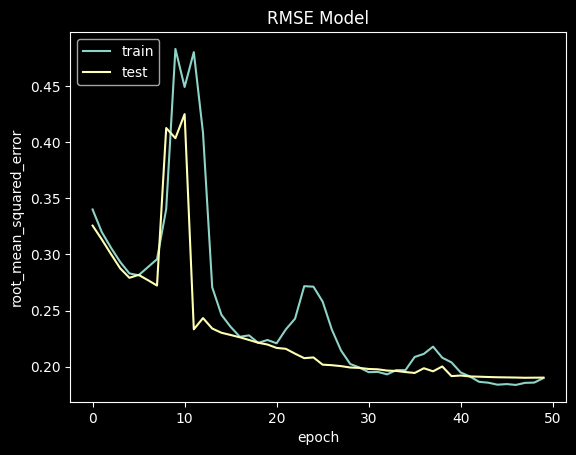

In [42]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('RMSE Model')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 4.4 Get Recommendation

In [43]:
 # Mengambil sample user
user_id = sample_user['user_id'].values[0]
anime_watched_by_user = dfRating[dfRating.user_id == user_id]
 
# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html 
anime_not_watched_by_user = dfRating[~dfRating['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id'] 
anime_not_watched_by_user = list(
    set(anime_not_watched_by_user)
     .intersection(set(anime_to_anime_encoded.keys()))
)
 
anime_not_watched_by_user = [[anime_to_anime_encoded.get(x)] for x in anime_not_watched_by_user]
user_encoder = user_to_user_encoded.get(user_id)

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched_by_user), anime_not_watched_by_user)
)

In [44]:
ratings = model.predict(user_anime_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_watched_by_user[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))

print('Top 10 anime recommendation')
print('----' * 8)
 
recommended_anime = dfAnime[dfAnime['anime_id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.name, ':', row.genre)

66/66 [==============================] - 0s 3ms/step
Showing recommendations for users: 20
Top 10 anime recommendation
--------------------------------
Fullmetal Alchemist: Brotherhood : Action, Adventure, Drama, Fantasy, Magic, Military, Shounen
Clannad: After Story : Drama, Fantasy, Romance, Slice of Life, Supernatural
Gintama : Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
Code Geass: Hangyaku no Lelouch R2 : Action, Drama, Mecha, Military, Sci-Fi, Super Power
Code Geass: Hangyaku no Lelouch : Action, Mecha, Military, School, Sci-Fi, Super Power
Cowboy Bebop : Action, Adventure, Comedy, Drama, Sci-Fi, Space
Monster : Drama, Horror, Mystery, Police, Psychological, Seinen, Thriller
One Outs : Psychological, Seinen, Sports
Gyakkyou Burai Kaiji: Ultimate Survivor : Game, Psychological, Seinen, Thriller
Mirai Shounen Conan : Adventure, Drama, Sci-Fi
